In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers

In [75]:
from google.colab import files
from abc import ABC, abstractmethod
from typing import List 
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import BertTokenizer, BertModel
from torch import nn, utils
from torch.utils.data import TensorDataset, RandomSampler, Dataset
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! ls  

'kaggle (1).json'   sample_submission.csv.zip   train.csv
 kaggle.json	    test.csv.zip	        train.csv.zip
 sample_data	    test_labels.csv.zip


In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [7]:
!ls

'kaggle (1).json'   sample_submission.csv.zip   train.csv
 kaggle.json	    test.csv.zip	        train.csv.zip
 sample_data	    test_labels.csv.zip


In [8]:
df = pd.read_csv("train.csv")[['id', 'comment_text', 'toxic']]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            159571 non-null  object
 1   comment_text  159571 non-null  object
 2   toxic         159571 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [11]:
df.sample(3)

,id,comment_text,toxic
69395,b9a155884df4de57,Please stop with your vandalizing of the Jim C...,0
28520,4b85fdafee74b2b1,"""::::::::1) The """"Dual-pane vs. tri-pane"""" arg...",0
14889,2757fcd573baa8af,that requires a response,0


In [28]:
len(df)

159571

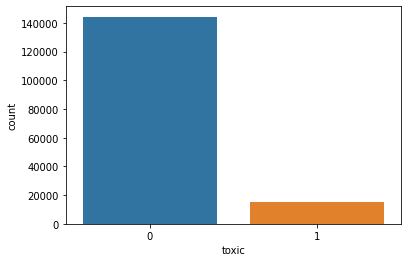

In [12]:
ax = sns.countplot(x="toxic", data=df)

In [13]:
df.rename(columns={'toxic': 'target'}, inplace = True)

train_df, validation_df = train_test_split(df, test_size = 0.2)
train_df.shape[0], validation_df.shape[0]

(127656, 31915)

In [46]:
class BaseClassifier(ABC):
  
  def __init__(self, bert_model, tokenizer):
    self._bert_model = bert_model
    self._bert_model.eval()
    self._tokenizer = tokenizer

  @abstractmethod
  def fit(self, df: pd.DataFrame):
    pass 

  @abstractmethod
  def predict(self, df: pd.DataFrame):
    pass 
  
  def text_to_tokens_ids(self, text):

    marked_text = CLS + text + SEP
    tokenized_text = self._tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
    indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

    return indexed_tokens

  def text_to_sentense_embeddingds(self, text: str, embeddings_layer: int):
    indexed_tokens = self.text_to_tokens_ids(text)
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_ids = [1] * len(indexed_tokens)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    with torch.no_grad():
      outputs = self._bert_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      
    return torch.mean(hidden_states[embeddings_layer], dim=1).detach().cpu().numpy().flatten() if embeddings_layer is not None else hidden_states
  
  def evaluate(self, df):
    predictions = self.predict(df)
    targets = df['target'].tolist()

    precision, recall, fscore, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return pd.DataFrame([(precision, recall, fscore)], columns = ['precision','recall', 'fscore'])

  
class NearestNeiborClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  

class TorchClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['target'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  
  




In [66]:
bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True).to(device)

bert.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
CLS = "{} ".format(tokenizer.cls_token)
SEP = " {}".format(tokenizer.sep_token)
MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512
SEP, CLS

(' [SEP]', '[CLS] ')

In [69]:
N_NEIGHBORS = 3

nearestNeiborClassifier = NearestNeiborClassifier(bert, tokenizer, 12, N_NEIGHBORS)
nearestNeiborClassifier.fit(train_df)
nearestNeiborClassifier.evaluate(validation_df)

100%|██████████| 200/200 [00:02<00:00, 85.44it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,fscore
0,0.0,0.0,0.0


In [70]:
class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):

        row = self._df.iloc[idx]
        return row['id'], row['comment_text_tokens_ids'], row['target'] if 'target' in self._df.columns else -1

In [76]:
def group_rows(rows):

    max_length = np.max([len(tokenes_ids) for _, tokenes_ids, _ in rows])

    ids = [id for id, _, _ in rows]

    tokenes_ids = torch.LongTensor([np.concatenate([tokenes_ids, np.repeat(tokenizer.pad_token_id, max_length - len(tokenes_ids))])
                   for id, tokenes_ids, target in rows])


    targets = [target for _, _, target in rows]

    masks = torch.LongTensor([np.concatenate([np.repeat(1, len(tokenes_ids)), np.repeat(0, max_length - len(tokenes_ids))])
          for _, tokenes_ids, _ in rows])
    
    return ids, tokenes_ids, masks, torch.FloatTensor(targets).reshape(-1, 1)


In [77]:
class RelevanceModel(nn.Module):

    def __init__(self, bert, embeddings_layer):

        super(RelevanceModel, self).__init__()

        self._embeddings_layer = embeddings_layer
        self._bert = bert

        self._bert.eval()

        for param in self._bert.parameters():
            param.requires_grad = False

        self.af1 = nn.LeakyReLU()
        self.fc1 = nn.Linear(768, 1)

    def forward(self, tokens, attention_mask):
        hidden_states = self._bert(tokens, attention_mask)[2]


        sentense_embeddingds = torch.mean(hidden_states[self._embeddings_layer], dim=1)

        out = self.af1(sentense_embeddingds)

        out = self.fc1(out)

        return out

    def reset_parameters(self):
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        return self

In [84]:
class DeepModel(BaseClassifier):


    def __init__(self, bert, tokenizer, embeddings_layer, batch_size,
                 prediction_threshold, learnning_rate = 0.001):
        BaseClassifier.__init__(self, bert, tokenizer)
        bert.to(device)
        self._model  = RelevanceModel(bert, embeddings_layer).reset_parameters()
        self._model.to(device)
        self._batch_size = batch_size
        self._prediction_threshold = prediction_threshold
        self._learnning_rate = learnning_rate

    def _calc_positive_weight(self, df: pd.DataFrame) -> float:
      weights = compute_class_weight('balanced', np.unique(train_df.target),  train_df.target)
      pos_weight = weights[1]/weights[0]
      return pos_weight   


    def _preprocessing(self, df):
      df['comment_text_tokens_ids'] = df['comment_text'].progress_apply(lambda text: self.text_to_tokens_ids(text))

    def fit(self, df: pd.DataFrame):

        self._model.train()

        positive_weight = self._calc_positive_weight(df)
        pos_weights_tensor = torch.Tensor([positive_weight])
       
        self._preprocessing(df)

        optimizer = torch.optim.Adam(self._model.parameters(), lr=self._learnning_rate)
        train_dataset = DatasetLoader(df)
        sampler = RandomSampler(train_dataset)

        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        batch_size=self._batch_size,
                                                        shuffle=False,
                                                        num_workers=4,
                                                        drop_last=False,
                                                        sampler=sampler,
                                                        collate_fn=group_rows)

        loss_fn  = nn.BCEWithLogitsLoss(pos_weight = pos_weights_tensor).to(device)

        for batch in range(1000):
          total_loss = 0.0
          for ids, tokends_ids, attention_mask, targets in train_data_loader:
                
              tokends_ids = tokends_ids.to(device)
              attention_mask = attention_mask.to(device)
              targets = targets.to(device)

              optimizer.zero_grad()

              output = self._model(tokends_ids, attention_mask)
              loss = loss_fn(output, targets)
    
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
            
          print('batch {} loss {}'.format(batch, total_loss/len(train_dataset)))

    def predict(self, df: pd.DataFrame):

      self._preprocessing(df)
      
      self._model.eval()

      predict_dataset_loader = DatasetLoader(df)

      predict_data_loader = torch.utils.data.DataLoader(predict_dataset_loader,
                                                              batch_size=self._batch_size,
                                                              shuffle=False,
                                                              num_workers=4,
                                                              drop_last=False,
                                                              collate_fn=group_rows)

      with torch.no_grad():

        predictions = {}
        
        for ids, tokends_ids, attention_mask, _ in predict_data_loader:
          tokends_ids = tokends_ids.to(device)
          attention_mask = attention_mask.to(device)
          
          logit = dm._model(tokends_ids, attention_mask)

          probs = torch.sigmoid(logit).detach().cpu().numpy().flatten()
          batch_predictions = probs > self._prediction_threshold

          for id, prediction in zip(ids, batch_predictions):
            predictions[id] = prediction 
          
      return df['id'].apply(lambda id: predictions[id]).tolist()
      

In [89]:
dm = DeepModel(bert, tokenizer, -1, 32, 0.65)

In [ ]:
dm.fit(train_df)

100%|██████████| 127656/127656 [03:39<00:00, 581.71it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
